In [2]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_parquet('../../data/cleaned_tom/0317_ckpt/hi_tom_train_2000.parquet')
dfh = pd.read_parquet('../../data/cleaned_tom/0317_ckpt/hi_tom_explore_tom_test_hint.parquet')
dfe = pd.read_parquet('../data/ToM_train_1200.parquet')
dft = pd.read_parquet('../data/ToM_test_1066.parquet')
dfexp = pd.read_csv('../data/expert_tom_data.csv')

In [4]:
print(len(df), len(dfh), len(dfe), len(dfexp))

2000 1600 1200 27


In [5]:
dfe['data_source'] = 'explore_tom'
dft['data_source'] = 'explore_tom'

In [6]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [7]:
dfs = df.groupby(['answer']).story.count().reset_index()

In [8]:
#SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

In [9]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [10]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        if dft['data_source'][i] == 'explore_tom':
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story_structure'][i], dft['question'][i])}
                ])
        else:
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
                ])
    return prompt

In [12]:
prompts = get_prompts(df)
df['prompt'] = prompts

prompts = get_prompts(dfe)
dfe['prompt'] = prompts

prompts = get_prompts(dfh)
dfh['prompt'] = prompts

prompts = get_prompts(dft)
dft['prompt'] = prompts

prompts = get_prompts(dfexp)
dfexp['prompt'] = prompts

In [13]:
dfe['story'] = dfe.story_structure
dft['story'] = dft.story_structure

In [14]:
dft.loc[dft.story.isna()]

,story_structure,infilled_story,question,answer,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,data_source,prompt,story


In [16]:
dfe.groupby(['is_interesting', 'question_type', ]).answer.count()

is_interesting  question_type                         
False           container_location-False                   11
                container_location-True                   162
                room_location-False                         4
                room_location-True                        423
True            container_location-False                   76
                container_location-True                    90
                ground_truth-container_location           118
                ground_truth-room_location                 21
                memory-container_location                 121
                memory-room_location                       19
                memory_before_event-container_location    146
                memory_before_event-room_location           3
                room_location-False                         2
                room_location-True                          4
Name: answer, dtype: int64

In [17]:
df.head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,data_source,prompt,ability,reward_model,extra_info
0,True,2,3,96,"Lily, Hannah, Emma, Jackson and Gracie entered...",Where does Lily think Gracie thinks Jackson th...,"A. green_drawer, B. red_container, C. blue_box...",green_cupboard,Where does Lily think Gracie thinks Jackson th...,green_cupboard,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'green_cupboard', 'style': 'r...","{'deception': True, 'question_order': 3, 'stor..."
1,False,1,3,29,"Mila, Benjamin, Emily, Noah and Isabella enter...",Where does Noah think Emily thinks Mila thinks...,"A. red_crate, B. red_bottle, C. blue_drawer, D...",red_crate,Where does Noah think Emily thinks Mila thinks...,red_crate,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'red_crate', 'style': 'rule'}","{'deception': False, 'question_order': 3, 'sto..."


In [18]:
col = ['prompt', 'answer', 'data_source', 'question', 'story']

In [19]:
dfr = pd.concat([df.loc[:, col], dfe.loc[:, col]], ignore_index=True)
dfr = dfr.sample(frac=1, replace=False, ignore_index=True)

In [20]:
dfr

,prompt,answer,data_source,question,story
0,"[{'role': 'system', 'content': 'You are a help...",green_cupboard,hi_tom,Where does Alexander think Evelyn thinks Emma ...,"Alexander, Emma, Aria, Evelyn and Charlotte en..."
1,"[{'role': 'system', 'content': 'You are a help...",red_crate,hi_tom,Where is the radish really?,"Evelyn dislikes the lime. Amelia, Ava, Isabell..."
2,"[{'role': 'system', 'content': 'You are a help...",blue_bathtub,hi_tom,Where is the cherry really?,"Lily, Avery, Charlotte, Gracie and William ent..."
3,"[{'role': 'system', 'content': 'You are a help...",backstage tent,explore_tom,In which room does Amelia think that Abigail w...,Abigail entered the backstage tent. Abigail mo...
4,"[{'role': 'system', 'content': 'You are a help...",red_crate,hi_tom,Where is the potato really?,"Isla, Mila, Jackson, Mason and Evelyn entered ..."
...,...,...,...,...,...
3195,"[{'role': 'system', 'content': 'You are a help...",blue_basket,hi_tom,Where does Olivia think Ella thinks the pumpki...,"Olivia, Ella, Lily, Chloe and Evelyn entered t..."
3196,"[{'role': 'system', 'content': 'You are a help...",blue_drawer,hi_tom,Where does William really think the lettuce is?,"Amelia, Jayden, William, Isla and Alexander en..."
3197,"[{'role': 'system', 'content': 'You are a help...",red_drawer,hi_tom,Where is the corn really?,"James, Lily, Benjamin, Gracie and Aria entered..."
3198,"[{'role': 'system', 'content': 'You are a help...",operations room,explore_tom,In which room does Owen think that Charlotte w...,Austin entered the briefing room. Austin enter...


In [21]:
data = Dataset.from_pandas(dfr)

In [22]:
len(data['prompt'])

3200

<Axes: ylabel='Count'>

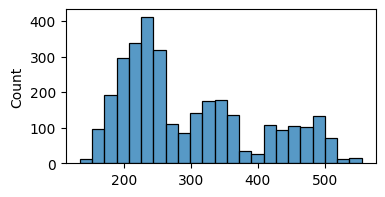

In [63]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [64]:
data

Dataset({
    features: ['prompt', 'answer', 'data_source', 'question', 'story'],
    num_rows: 3200
})

In [65]:
data.to_parquet('../data/train/ToM_train_HiEx.parquet')

Creating parquet from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 458.57ba/s]


7598692

**Verl**

In [67]:
# add a row to each data item that represents a unique id
def make_map_fn(split):

    def process_fn(example, idx):
        question = example.pop('question')
        story = example.pop('story')
        question = SYSTEM_PROMPT + f""" Read the following story and answer the question. Story: {story}\n Question:{question}"""

        solution = example.pop('answer')
        data = {
            "data_source": 'HiTom+ExploreTom',
            "prompt": [{
                "role": "user",
                "content": question
            }],
            "ability": "tom",
            "reward_model": {
                "style": "rule",
                "ground_truth": solution
            },
            "extra_info": {
                'split': split,
                'index': idx
            }
        }
        return data

    return process_fn

In [68]:
train_dataset_verl = data.map(function=make_map_fn('train'), with_indices=True)

Map: 100%|██████████| 3200/3200 [00:00<00:00, 36610.59 examples/s]


In [42]:
train_dataset_verl.to_parquet('../data/test/ToM_train_HiExTi_verl.parquet')

Creating parquet from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 635.93ba/s]


4683079

In [30]:
extra_info = []
for i, row in dft.iterrows():
    extra_info.append({'question_type':row['question_type'], 
                       'question_order':row['nth_order'],
                       'is_interesting':row['is_interesting'],
                       'story_type':row['story_type']
                       })
dft['extra_info'] = extra_info

In [31]:
dfh[:1000].head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,...,reward_model,extra_info,story_structure,infilled_story,question_type,params,nth_order,is_interesting,story_type,story_structure_wn
0,False,1.0,4.0,89.0,"Benjamin, Emily, Mason, Evelyn and Jackson ent...",Where does Jackson think Benjamin thinks Emily...,"A. green_treasure_chest, B. green_bottle, C. g...",green_suitcase,Where does Jackson think Benjamin thinks Emily...,green_suitcase,...,"{'ground_truth': 'green_suitcase', 'style': 'r...","{'deception': False, 'question_order': 4, 'sto...",None,None,None,None,NaN,None,None,None
1,True,3.0,4.0,46.0,"Mason, Noah, Hannah, Ethan and Alexander enter...",Where does Hannah think Noah thinks Mason thin...,"A. green_box, B. blue_container, C. blue_pantr...",red_drawer,Where does Hannah think Noah thinks Mason thin...,red_drawer,...,"{'ground_truth': 'red_drawer', 'style': 'rule'}","{'deception': True, 'question_order': 4, 'stor...",None,None,None,None,NaN,None,None,None


In [32]:
test_tomi = load_dataset('parquet', data_files='../data/test/test_tomi.parquet')['train']

In [33]:
dftomi = pd.DataFrame(test_tomi)

In [34]:
dftomi.head(2)

,story,question,answer,question_type,question_type2,prompt
0,Jackson entered the hall. Chloe entered the ha...,Where was the boots at the beginning?,bathtub,true_belief,memory,[{'content': 'You are a helpful assistant. The...
1,Jackson entered the hall. Chloe entered the ha...,Where will Chloe look for the boots?,pantry,true_belief,first_order_1_no_tom,[{'content': 'You are a helpful assistant. The...


In [35]:
extra_info = []
for i, row in dftomi.iterrows():
    extra_info.append({'question_type':row['question_type'], 
                       'question_type2':row['question_type2']
                       })
dftomi['extra_info'] = extra_info

In [36]:
dftomi['data_source']='tomi'

In [37]:
col_test = ['prompt', 'answer', 'data_source', 'question', 'story', 'extra_info']

In [38]:
df_test = pd.concat([dft.loc[:, col_test], dfh.loc[dfh.data_source!='explore_tom', col_test], dftomi.loc[:, col_test]], ignore_index=True)
df_test = df_test.sample(frac=1, replace=False, ignore_index=True)

Exp 57	1009
72	928
876	5118



In [39]:
len(df_test)

8060

In [40]:
df_test.groupby('story').question.count()

story
Abigail dislikes the pear Emma entered the playroom. Abigail entered the playroom. The pear is in the bucket. Emma exited the playroom. Lily entered the playroom. Abigail moved the pear to the treasure_chest. Emma entered the playroom.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [41]:
df_test

,prompt,answer,data_source,question,story,extra_info
0,"[{'role': 'system', 'content': 'You are a help...",black nylon backpack,explore_tom,In which container will Abigail search for the...,Kayla entered the backstage tent. Kayla moved ...,"{'question_type': 'container_location-True', '..."
1,[{'content': 'You are a helpful assistant. The...,treasure_chest,tomi,Where does Aiden think that Jack searches for ...,Aiden entered the garden. Aiden likes the slip...,"{'question_type': 'false_belief', 'question_ty..."
2,[{'content': 'You are a helpful assistant. The...,suitcase,tomi,Where will Ava look for the slacks?,Ava entered the garden. Hunter entered the gar...,"{'question_type': 'false_belief', 'question_ty..."
3,[{'content': 'You are a helpful assistant. The...,envelope,tomi,Where was the celery at the beginning?,Hunter is in the garden. Jayden entered the ba...,"{'question_type': 'true_belief', 'question_typ..."
4,"[{'role': 'system', 'content': 'You are a help...",red_drawer,hi_tom,Where is the asparagus really?,"Hannah, Mason, Jackson, Ella and James entered...","{'deception': False, 'question_order': 0, 'sto..."
...,...,...,...,...,...,...
8055,"[{'role': 'system', 'content': 'You are a help...",cardboard file box,explore_tom,In which container was the pocket-sized notebo...,Justin entered the student lounge. Justin move...,{'question_type': 'memory_before_event-contain...
8056,"[{'role': 'system', 'content': 'You are a help...",green_cupboard,hi_tom,Where does Jackson think Isabella thinks Natha...,"Jackson, Nathan, Isabella, Lily and Ella enter...","{'deception': False, 'question_order': 4, 'sto..."
8057,"[{'role': 'system', 'content': 'You are a help...",blue_crate,hi_tom,Where does Jack think Benjamin thinks the toma...,"Emma, Jack, Alexander, Benjamin and Emily ente...","{'deception': False, 'question_order': 2, 'sto..."
8058,[{'content': 'You are a helpful assistant. The...,treasure_chest,tomi,Where will Chloe look for the apple?,Chloe hates the potato Mason likes the suit Ja...,"{'question_type': 'second_order_false_belief',..."


In [150]:
data = Dataset.from_pandas(df_test)

data.to_parquet('../data/test/ToM_test_HiExTi.parquet')

Creating parquet from Arrow format: 100%|██████████| 9/9 [00:00<00:00, 465.72ba/s]


10798423

In [38]:
data_test = Dataset.from_pandas(df_test)

In [52]:
dfexp['extra_info']={'question_type':'expert'}

In [53]:
df_test_all = pd.concat([dft.loc[:, col_test], dfh.loc[dfh.data_source!='explore_tom', col_test], dftomi.loc[:, col_test], dfexp.loc[:, col_test]], ignore_index=True)
#df_test_all = df_test_all.sample(frac=1, replace=False, ignore_index=True)

In [54]:
data = Dataset.from_pandas(df_test_all)

data.to_parquet('../data/test/ToM_test_all.parquet')

Creating parquet from Arrow format: 100%|██████████| 9/9 [00:00<00:00, 790.72ba/s]


10827846

In [80]:
# add a row to each data item that represents a unique id
def make_map_fn_test(split):

    def process_fn(example, idx):
        question = example.pop('question')
        story = example.pop('story')
        question = SYSTEM_PROMPT + f""" Read the following story and answer the question. Story: {story}\n Question:{question}"""

        solution = example.pop('answer')
        data = {
            "prompt": [{
                "role": "user",
                "content": question
            }],
            "ability": "tom",
            "reward_model": {
                "style": "rule",
                "ground_truth": solution
            },
        }
        return data

    return process_fn

In [81]:
test_dataset_verl = data_test.map(function=make_map_fn_test('train'), with_indices=True)

Map: 100%|██████████| 8660/8660 [00:00<00:00, 27910.67 examples/s]


In [82]:
test_dataset_verl.to_parquet('../data/test/ToM_test_HiExTi_verl.parquet')

Creating parquet from Arrow format: 100%|██████████| 9/9 [00:00<00:00, 603.26ba/s]


9758322